## SenNetworks: Hacking the Human Vasculature in 3D

#### Authors: Andrew Kettle and Hitarth Ghandi

In [5]:
# Packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import torchvision.io
import pandas as pd
import os
import shutil

from sklearn.model_selection import train_test_split

### Dataset
In the following two cells, we wrote code to handle the dataset ingestion. This particular dataset has overlapping names that need to be addressed. 

In [69]:
# Dataset to be used by pytorch loaders
class SenDataset(torch.utils.data.Dataset):

	def __init__(self, run_type):
		self.run_type = run_type
		self.image_paths = []
		self.label_paths = []

	def setPaths(self, image_paths, label_paths):
		self.image_paths = image_paths

		# Guard
		if self.run_type != 'test':
			self.label_paths = label_paths

	def setImagePath(self, image_paths):
		self.image_paths = image_paths

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):
		if self.run_type != 'test':
			image = cv2.imread(self.image_paths[idx])
			label = cv2.imread(self.label_paths[idx])
			return image, label
		else:
			image = cv2.imread(self.image_paths[idx])
			return image, ''

# Rename items in the dataset so there is no overlap (only run this once!)
def renameDataset():
	root_dir = os.path.join(os.getcwd(), "data")
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]

	# Iterate over each subset
	for p in paths:	
		
		image_path = os.path.join(p, "images")
		label_path = os.path.join(p, "labels")
		image_names = os.listdir(image_path)
		label_names = os.listdir(label_path)

		# Name to append for each file (splitting is platform specific)
		append_name = p.split('/')[-1]

		revised_image_names = [append_name + '_' + name for name in image_names]
		revised_label_names = [append_name + '_' + name for name in label_names]

		# Rename images
		for iname, upiname in zip(image_names, revised_image_names):
			shutil.move(os.path.join(image_path, iname), os.path.join(image_path, upiname))
		# Rename labels
		for lname, uplname in zip(label_names, revised_label_names):
			shutil.move(os.path.join(label_path, lname), os.path.join(label_path, uplname))

# Write function for populating numpy arrays associated with the data
def buildDataset(root_dir: str, run_type: str):
	""" Populate the image and label arrays

	Args:
		root_dir (str): Path to root dir (where training or testing may take place)
		run_type (str): either 'train' or 'test'
	"""

	image_paths = []
	label_paths = []

	# Logic for training or testing
	if run_type == 'train':
		working_dir = os.path.join(root_dir, "train")
	elif run_type == 'test':
		working_dir = os.path.join(root_dir, "test")
	else:
		print("Unsupported run_type in the buildDataset function")
		assert(False) # Quick hack to exit execution

	paths = os.listdir(working_dir)
	paths = [os.path.join(working_dir, p) for p in paths]

	for p in paths:

		image_path = os.path.join(p, "images")
		image_names = [os.path.join(image_path, name) for name in os.listdir(image_path)]
		image_paths.append(np.array(image_names))

		if run_type == 'train':
			label_path = os.path.join(p, "labels")
			label_names = [os.path.join(label_path, name) for name in os.listdir(label_path)]
			label_paths.append(np.array(label_names))
	
	image_paths = np.concatenate(image_paths)

	if run_type == 'train':
		label_paths = np.concatenate(label_paths)

	return image_paths, label_paths

In [7]:
# Uncomment this on first run to format the dataset properly
# renameDataset()

In [59]:
# Ingest data, store in numpy arrays (done here so that we can split)
Xtr, Ytr = buildDataset(os.path.join(os.getcwd(), 'data'), 'train')
print(f"Xtr.shape: {Xtr.shape} Ytr.shape: {Ytr.shape}")

Xte, _ = buildDataset(os.path.join(os.getcwd(), 'data'), 'test')
print(f"Xte.shape: {Xte.shape}")

Xtr.shape: (7963,) Ytr.shape: (7429,)
Xte.shape: (6,)


#### Cleaning

Observe that the training set has fewer labels than images. Since we are data rich, we will elect to toss out the samples that don't have labels for the sake of simplicity.

In [60]:
# Trim file extensions
a = np.array([x.split('.')[0].split('/')[-1] for x in Xtr])
b = np.array([y.split('.')[0].split('/')[-1] for y in Ytr])

# Find overlap
c = np.where(np.intersect1d(a, b))

# Drop extra items from training set
Xtr = Xtr[c]

Split data into training and testing using 80/20 split

In [64]:
# Split dataset into training and validation
Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=0.2, shuffle=True)
print(f"Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
print(f"Xval: {Xval.shape}, Yval: {Yval.shape}")

Xtr: (3042,), Ytr: (3042,)
Xval: (761,), Yval: (761,)


#### Create dataset and dataloader

In [71]:
# Create datasets and set paths
trds = SenDataset('train')
trds.setPaths(Xtr, Ytr)

valds = SenDataset('validation')
valds.setPaths(Xval, Yval)

teds = SenDataset('test')
teds.setImagePath(Xte)

batch_size = 16

train_loader = torch.utils.data.DataLoader(trds, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valds, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(teds, batch_size=batch_size)

(1928, 1928, 3)
(1928, 1928, 3)


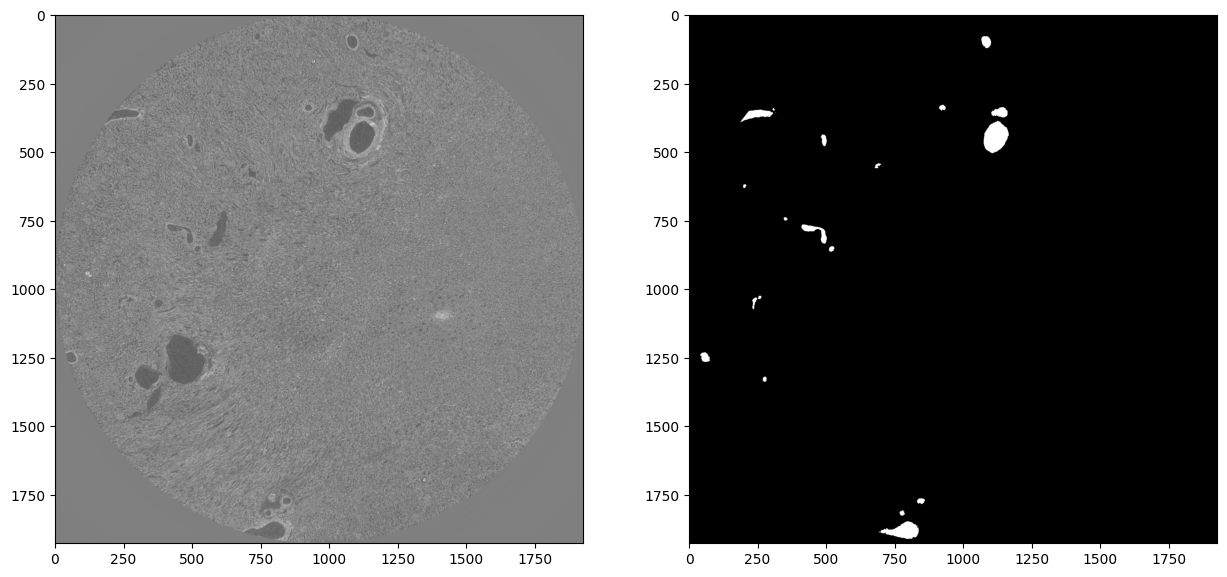

In [72]:
# Show example of image label

image, label = trds.__getitem__(3)

print(image.shape)
print(label.shape)

# Display image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image)
ax[1].imshow(label)
plt.show()

### Try using SAM on training data